# 4.2.1 CD8+ T-cells analysis
**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-20"

## Introduction

CD8+ cells only

## Libraries

In [2]:
options(warn = -1, verbose = FALSE)
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(harmony)
library(scater) 
library(scran)
library(ComplexHeatmap)
}))

In [3]:
set.seed(0)
source(here("utils/bin.R"))
source(here("utils/style.R"))

source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))

## Load data

In [4]:
seurat_obj <- readRDS(here(glue("{annot}/{robj_dir}/4.2-subset_tcell_noannot.rds")))

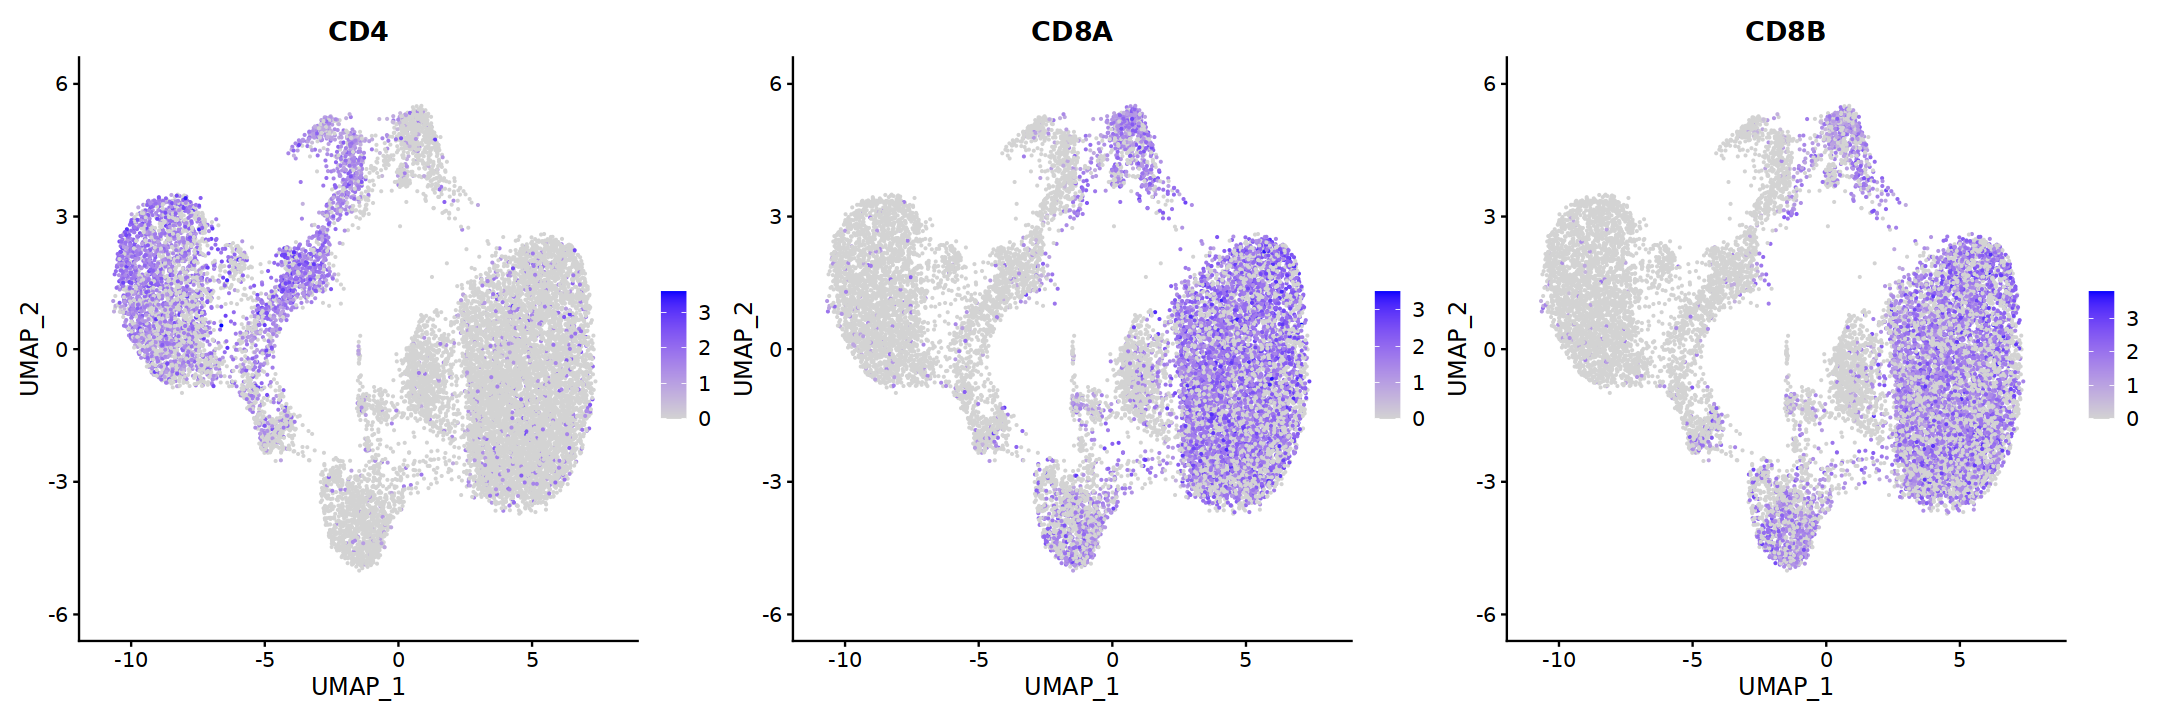

In [5]:
options(repr.plot.width =18, repr.plot.height = 6, warn=-1,verbose = FALSE)
FeaturePlot(object = seurat_obj, reduction = "umap",
    features = c("CD4", "CD8A", "CD8B"), order = F, ncol=3)

## Subset to CD8 only

In [6]:
cd8_clusters <- c("0","1","3","4","8","10")
seurat_obj <- subset(x = seurat_obj, idents=cd8_clusters)

In [7]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]


FALSE  TRUE 
25009  1708 


In [8]:
list_objects <- SplitObject(seurat_obj, split.by = "sample_id")
fractions <- names(list_objects)

In [9]:
find_hvgs <- function(sam, list_objects) {
    
    list_objects[[sam]] <- list_objects[[sam]]  %>% 
        NormalizeData(
            normalization.method = "LogNormalize",
            scale.factor = 1e4)
    
    sce <- as.SingleCellExperiment(list_objects[[sam]])
    gene_var <- modelGeneVar(sce)
    
    tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)
    
    plt <- gene_var %>% 
        as.data.frame() %>% 
        ggplot(aes(mean, total)) +
        geom_point() +
        geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
        labs(x = "Mean of log-expression", y = "Variance of log-expression") + 
        ggtitle(sam) +
        geom_text(data=tops, aes(mean,total,label=rownames(tops)))
    
    hvg <- getTopHVGs(gene_var,fdr.threshold = 0.05)
    list(plots=plt, hvgs=hvg)  
}

plts <- lapply(names(list_objects), function(sam) find_hvgs(sam, list_objects)$plots)
hvgs <- lapply(names(list_objects), function(sam) find_hvgs(sam, list_objects)$hvgs)

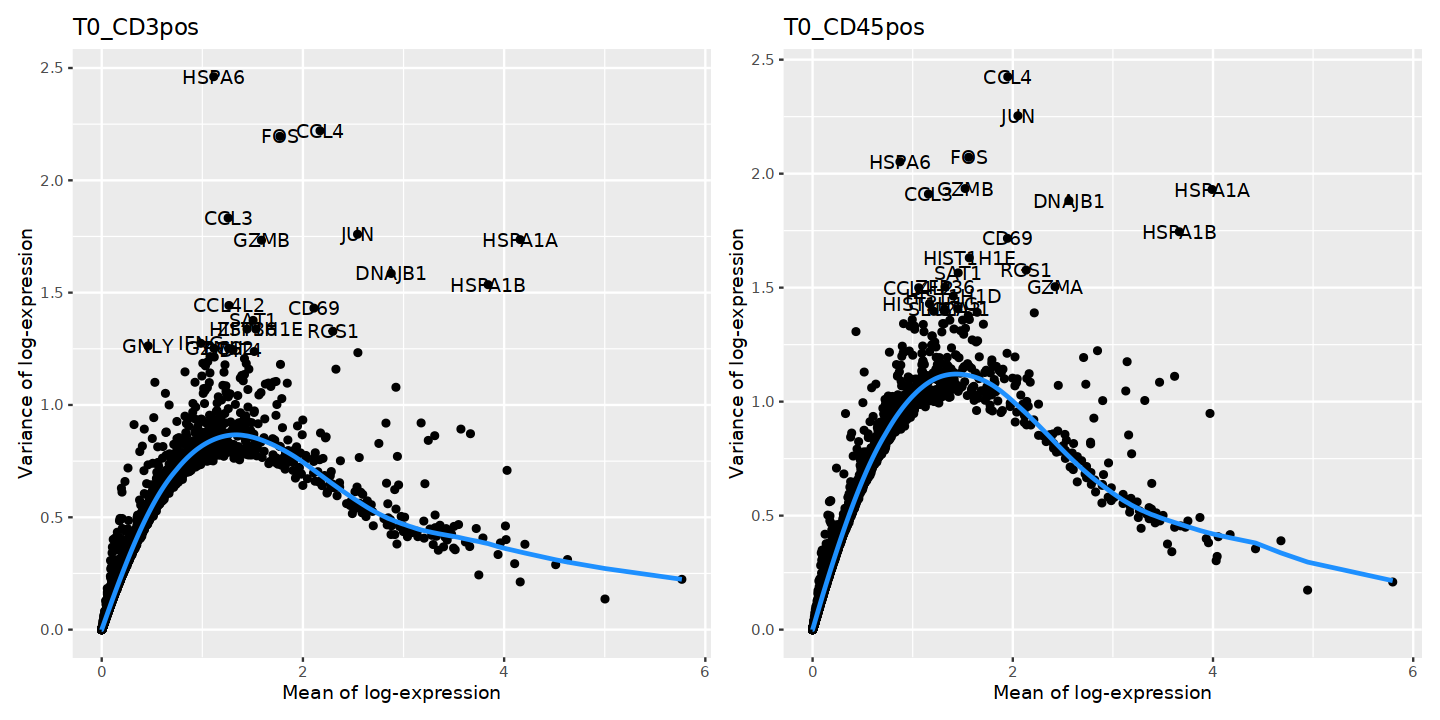

In [10]:
options(repr.plot.width = 12, repr.plot.height = 6, warn=-1,verbose = FALSE)
plts[[1]]+plts[[2]]

In [11]:
hvg_common <- union(hvgs[[1]], hvgs[[2]])
length(hvg_common)

[1] 2511

### Normalization and Embedding

In [12]:
seurat_obj <- NormalizeData(
seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvg_common) %>% 
  RunPCA(features=hvg_common)

Centering and scaling data matrix

PC_ 1 
Positive:  IL7R, LEF1, ZNF683, TCF7, BACH2, PLAC8, LINC02446, XCL1, AREG, KLRD1 
	   XCL2, KLRC2, TXNIP, TAFA1, SELL, PELI2, EPHA4, FMN1, SOX4, GNLY 
	   NR4A1, TRDC, KCNQ5, IGF1R, FER, KLF3, MT-CYB, AC022182.1, BTG2, DDIT4 
Negative:  GZMA, GZMK, NKG7, CST7, CD74, CCL5, RGS1, GAPDH, HLA-DRB1, PRF1 
	   GZMB, CCL4, GZMH, CCL3, CCL4L2, VCAM1, HLA-DRA, FCGR3A, MT2A, TNFRSF9 
	   HMGB2, LINC01934, ACTG1, UBC, H3F3B, CADM1, FTL, TUBB, MKI67, TOP2A 
PC_ 2 
Positive:  CCL5, CST7, NKG7, FTL, GZMK, PRF1, IL32, GZMA, GZMH, FCGR3A 
	   CTSW, LTB, TXNIP, CCL4L2, IFITM1, GZMB, VCAM1, TRBV6-6, CCL4, TRAV10 
	   RGS1, UBC, TRBV12-3, CX3CR1, TRAV8-1, ID2, TRAV16, CCL3, TRAV14DV4, TRAV19 
Negative:  MKI67, RRM2, TOP2A, HIST1H3B, STMN1, HIST1H3C, CENPF, ASPM, HIST1H1B, HIST1H2AH 
	   TUBA1B, HIST1H2AL, HIST1H3F, HIST1H4C, TUBB, HMGB2, HIST1H1C, HIST1H1E, HIST2H2BF, HIST1H1D 
	   HLA-DRA, KCNQ5, FOS, FOSB, HSPH1, MT2A, UBB, HSPD1, IL7R, XCL1 
PC_ 3 
Positive:  H

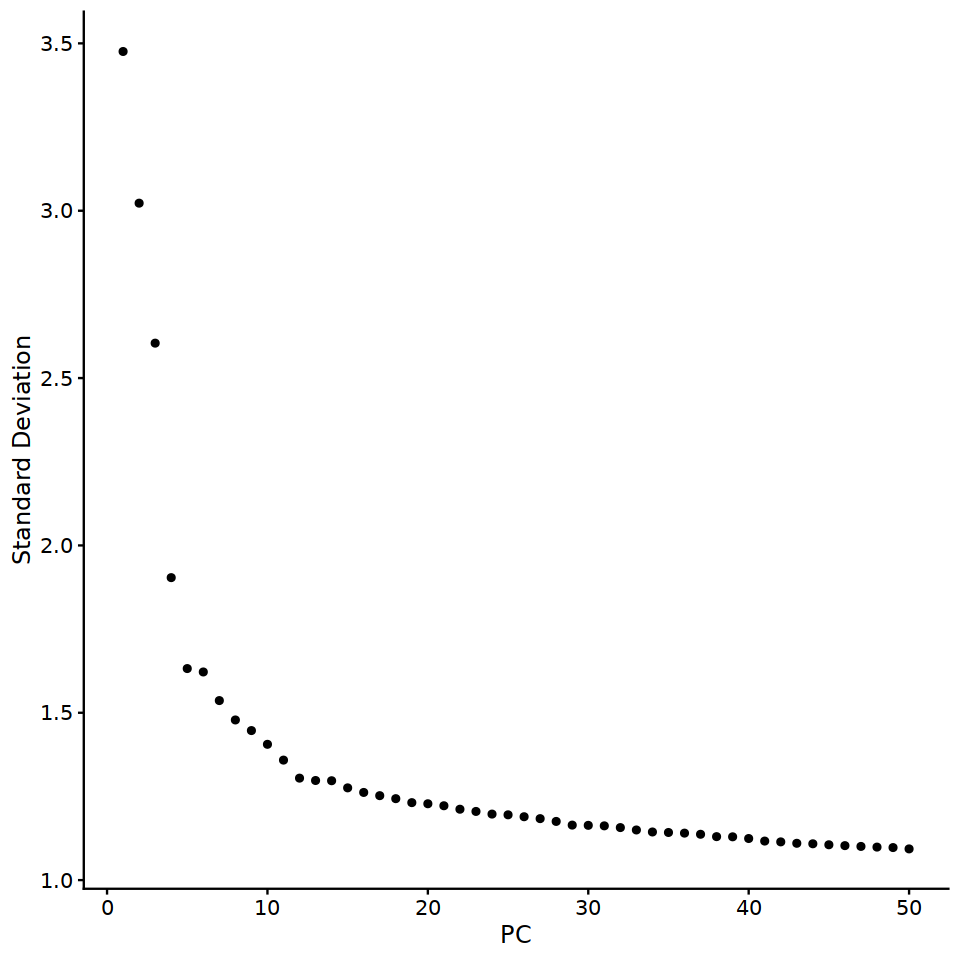

In [13]:
options(repr.plot.width = 8, repr.plot.height = 8, warn=-1,verbose = FALSE)
ElbowPlot(seurat_obj, n=50)

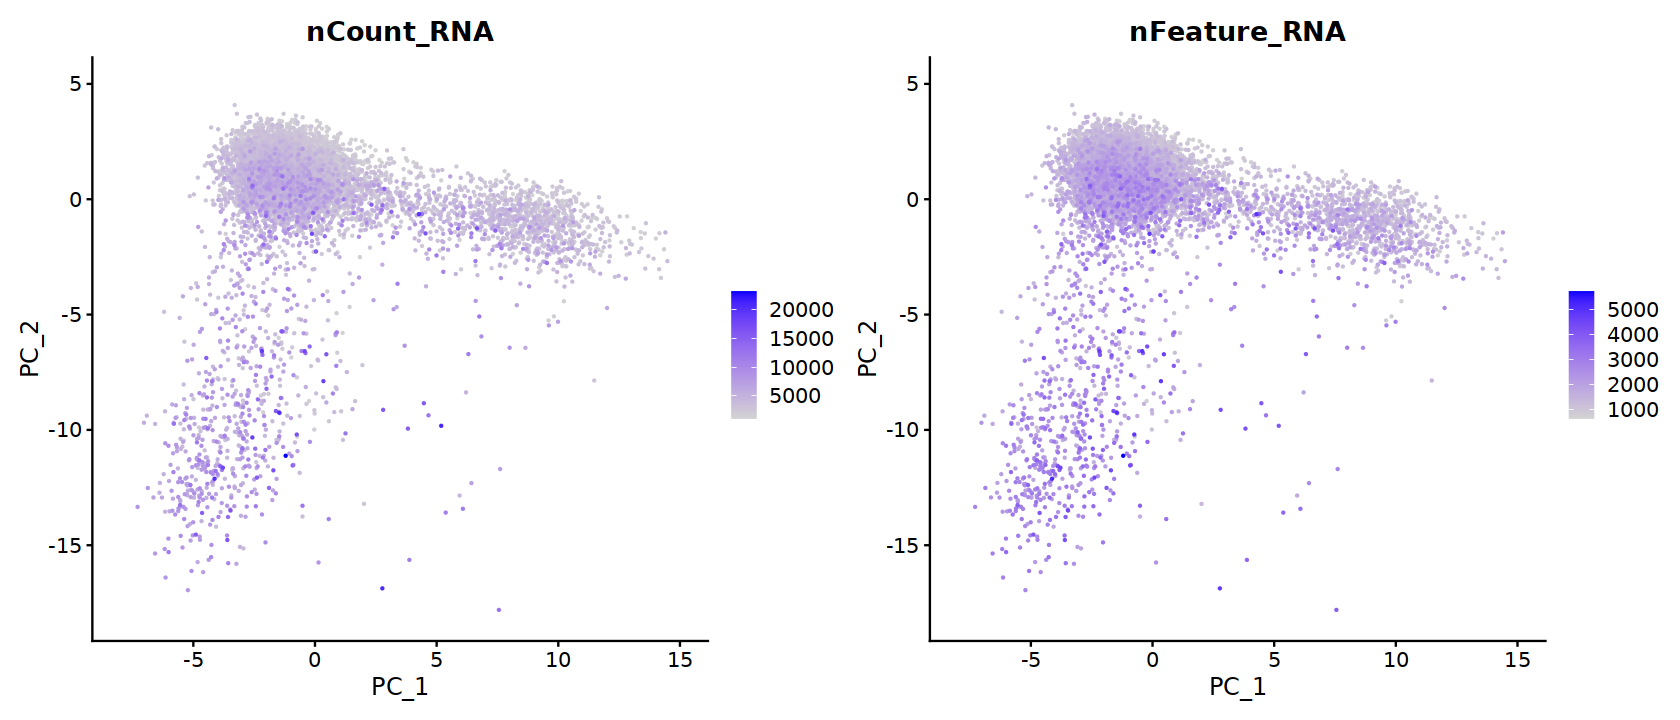

In [14]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
    features = c("nCount_RNA", "nFeature_RNA"), order = T)

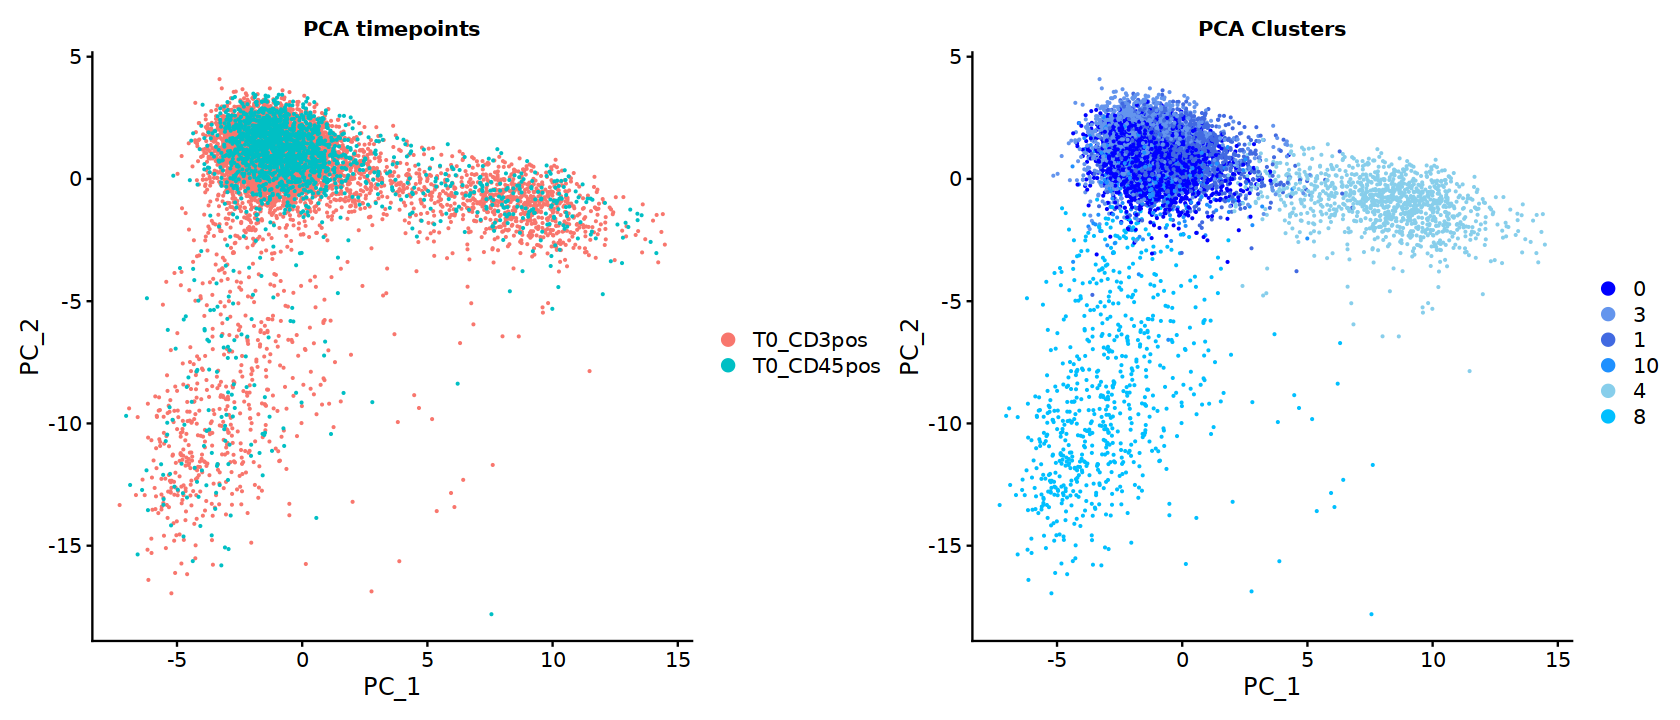

In [15]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
dp1 <- DimPlot(
  seurat_obj,
  reduction = "pca",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('PCA timepoints') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dp2 <- DimPlot(
  seurat_obj,
  reduction = "pca",
  group.by = "Tcell_clusters",
  pt.size = 0.1,
  cols = tumor_pal
) + ggtitle('PCA Clusters') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dp1 + dp2

## Key descriptive factors 

From Li et al 2023

In [16]:
gene_functionality <- list("Effector\nmolecules" = c("IFNG", "NKG7", "PRF1", "GZMK", "GZMB", "GZMA", "GZMH","FASLG"),
                "Costimulation and\nActivation"= c("CD27", "CD82", "TNFRSF4", "TNFRSF9", "CXCR3"), 
                "Coinhibitory\nReceptors"=c("PDCD1", "LAG3", "TIGIT", "HAVCR2"),
                "Exhaustion\nMarkers"=c("TOX", "ENTPD1", "BATF", "PRDM1"), 
                "Chemokines"=c("CCL3", "CCL4", "CCL5", "CXCL13"),
                "Proliferation"=c("STMN1", "MKI67", "UBE2C", "PCLAF"),
                "Residency"=c("ITGAE", "ZNF683", "CD44", "ITGA1", "CD69"))

Pseudo-bulk per cluster

In [17]:
list_objects <- SplitObject(seurat_obj, split.by = "ident")
col_names <-  names(list_objects)

counts <- matrix(nrow=dim(list_objects[[1]]@assays$RNA@counts)[1], ncol=0)
lib_sizes <- c()

for (d in col_names){
  obj <- list_objects[[d]]
  
  m <- as.matrix(obj@assays$RNA@counts)
  c <- rowSums(m)
  counts <- cbind(counts, c)
  
  ls <- sum(colSums(m))
  lib_sizes <- c(lib_sizes, ls)
}
colnames(counts)<-col_names

logcpm <- counts
for (i in seq_along(names(list_objects))){
  ls <- lib_sizes[i]
  d <- colnames(logcpm)[i]
  logcpm[, d]<-log2((logcpm[, d]/ls*1e6)+1) 
}

# scaling as z-scoring 
mat1 <- t(scale(t(logcpm)))
mat1 <- mat1[unlist(gene_functionality, use.names = F),]

# Sorting clusters by HAVCR2 gene
mat1 <- mat1[,order(mat1["HAVCR2",])]
df_col <- data.frame(CD8_clusters=colnames(mat1))
row.names(df_col) <- colnames(mat1)

In [18]:
df_row <- data.frame(
  functionality = rep(names(gene_functionality), times = sapply(gene_functionality, length)),
  genes = unlist(gene_functionality)
)
row.names(df_row) <- df_row$genes

In [19]:
gene_to_functionality <- unlist(lapply(names(gene_functionality), function(x) {
  setNames(rep(x, length(gene_functionality[[x]])), gene_functionality[[x]])
}))
functionality_factor <- factor(gene_to_functionality[rownames(mat1)], levels = names(gene_functionality))

In [20]:
heatmap <- Heatmap(
  mat1,
  col = rev(c('#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695')),
  name = "z-score\nnorm. expr.",
  column_title = "CD8 clusters",
  cluster_columns = FALSE,
  cluster_rows = FALSE,
  show_row_names = TRUE,
  show_column_names = FALSE,
  column_title_gp = gpar(fontsize = 14, fontface = "bold"),
  row_names_gp = gpar(fontsize = 12),
  top_annotation = HeatmapAnnotation(
      text = anno_text(colnames(mat1), rot = 0,
                      offset = unit(1, "npc"),just = "center", 
                      height=unit(0.2, "cm")), 
      df = df_col, 
      col = list(CD8_clusters=tumor_pal[as.character(cd8_clusters)]),
      show_annotation_name = FALSE),
 heatmap_legend_param = list(legend_direction = "horizontal", 
                                legend_width = unit(5, "cm")),
    
  row_split = functionality_factor,
)

svg(here(glue("{annot}/{plt_dir}/4.2.1-CD8_markers_heatmap.svg")),
   width = 4, height = 13)
draw(heatmap, merge_legend = TRUE, column_dend_side = "bottom",
     heatmap_legend_side = "bottom",
    padding = unit(c(2, 10, 5,15), "mm"))
dev.off()

png 
  2

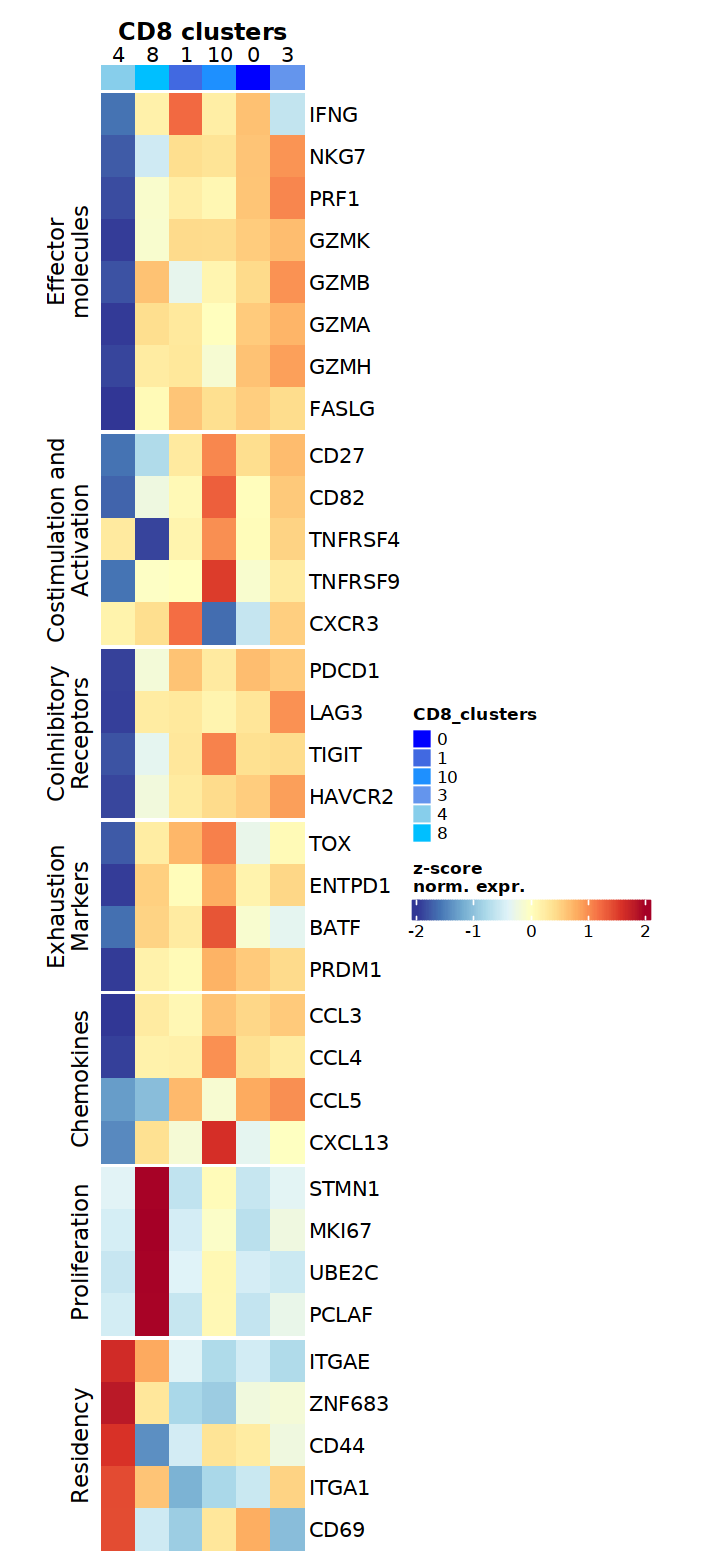

In [21]:
options(repr.plot.width = 6, repr.plot.height = 13, warn=-1,verbose = FALSE)
draw(heatmap, merge_legend = TRUE, column_dend_side = "top",
    padding = unit(c(2, 10, 5,15), "mm"))

# Session Info

In [22]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ComplexHeatmap_2.10.0       scran_1.22.1               
 [3] scater_1.22.0               scuttle_1.4.0              
 [5] SingleCellExperiment_1.16.0 SummarizedExperiment_1.24.0
 [7] Biobase_2.54.0              GenomicRanges_1.46.1       
 [9] GenomeIn